In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import missingno as msno
from lightgbm import LGBMRegressor
import random
from sklearn.impute import SimpleImputer
import time 
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_data = '/content/drive/MyDrive/OpenClassRooms/Projet 8/data.csv'
path_sample = '/content/drive/MyDrive/OpenClassRooms/Projet 8/sample_submission.csv'
data = pd.read_csv(path_data, index_col='row_id')
sub = pd.read_csv(path_sample)

In [4]:
data.shape

(1000000, 80)

In [5]:
data

,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,...,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
row_id,,,,,,,,,,,,,,,,,,,,,
0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,...,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,...,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,...,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,...,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,...,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,0.844075,...,1.799592,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733
999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,1.648023,...,1.909697,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807
999997,0.147534,-0.715276,-0.465049,-1.988941,-1.594535,-1.044882,3.159455,-0.634108,0.890382,-1.212444,...,2.891854,3.105002,-3.470520,NaN,0.096988,0.569255,3.609790,-0.584108,-1.492096,-0.997502


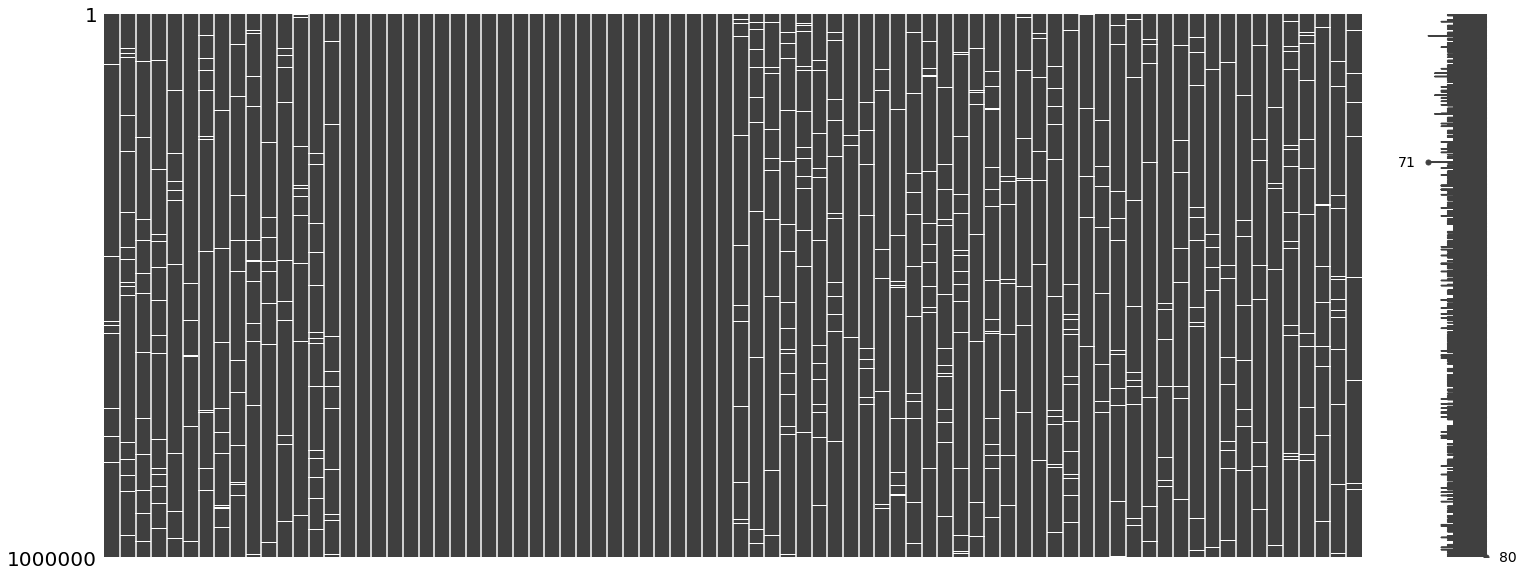

In [6]:
msno.matrix(data)

In [7]:
print(f"Dataset contains {data.isna().sum().sum() / data.size * 100} % of Nans")

Dataset contains 1.25 % of Nans


In [8]:
data.dtypes.value_counts()

float64    55
int64      25
dtype: int64

In [9]:
#shows only int64 columns

mask_int64 = data.dtypes == 'int64'
data.loc[:, data.columns[mask_int64]].columns

Index(['F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6', 'F_2_7',
       'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14',
       'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20', 'F_2_21',
       'F_2_22', 'F_2_23', 'F_2_24'],
      dtype='object')

In [10]:
def split_cols(col):
    splitted = col.split('_')
    return splitted[1], splitted[2]

In [11]:
print(f"Columns starting with F_2 have {data.rename(columns=lambda x: split_cols(x)[0]).loc[:,'2'].isna().sum().sum()} Nans")

Columns starting with F_2 have 0 Nans


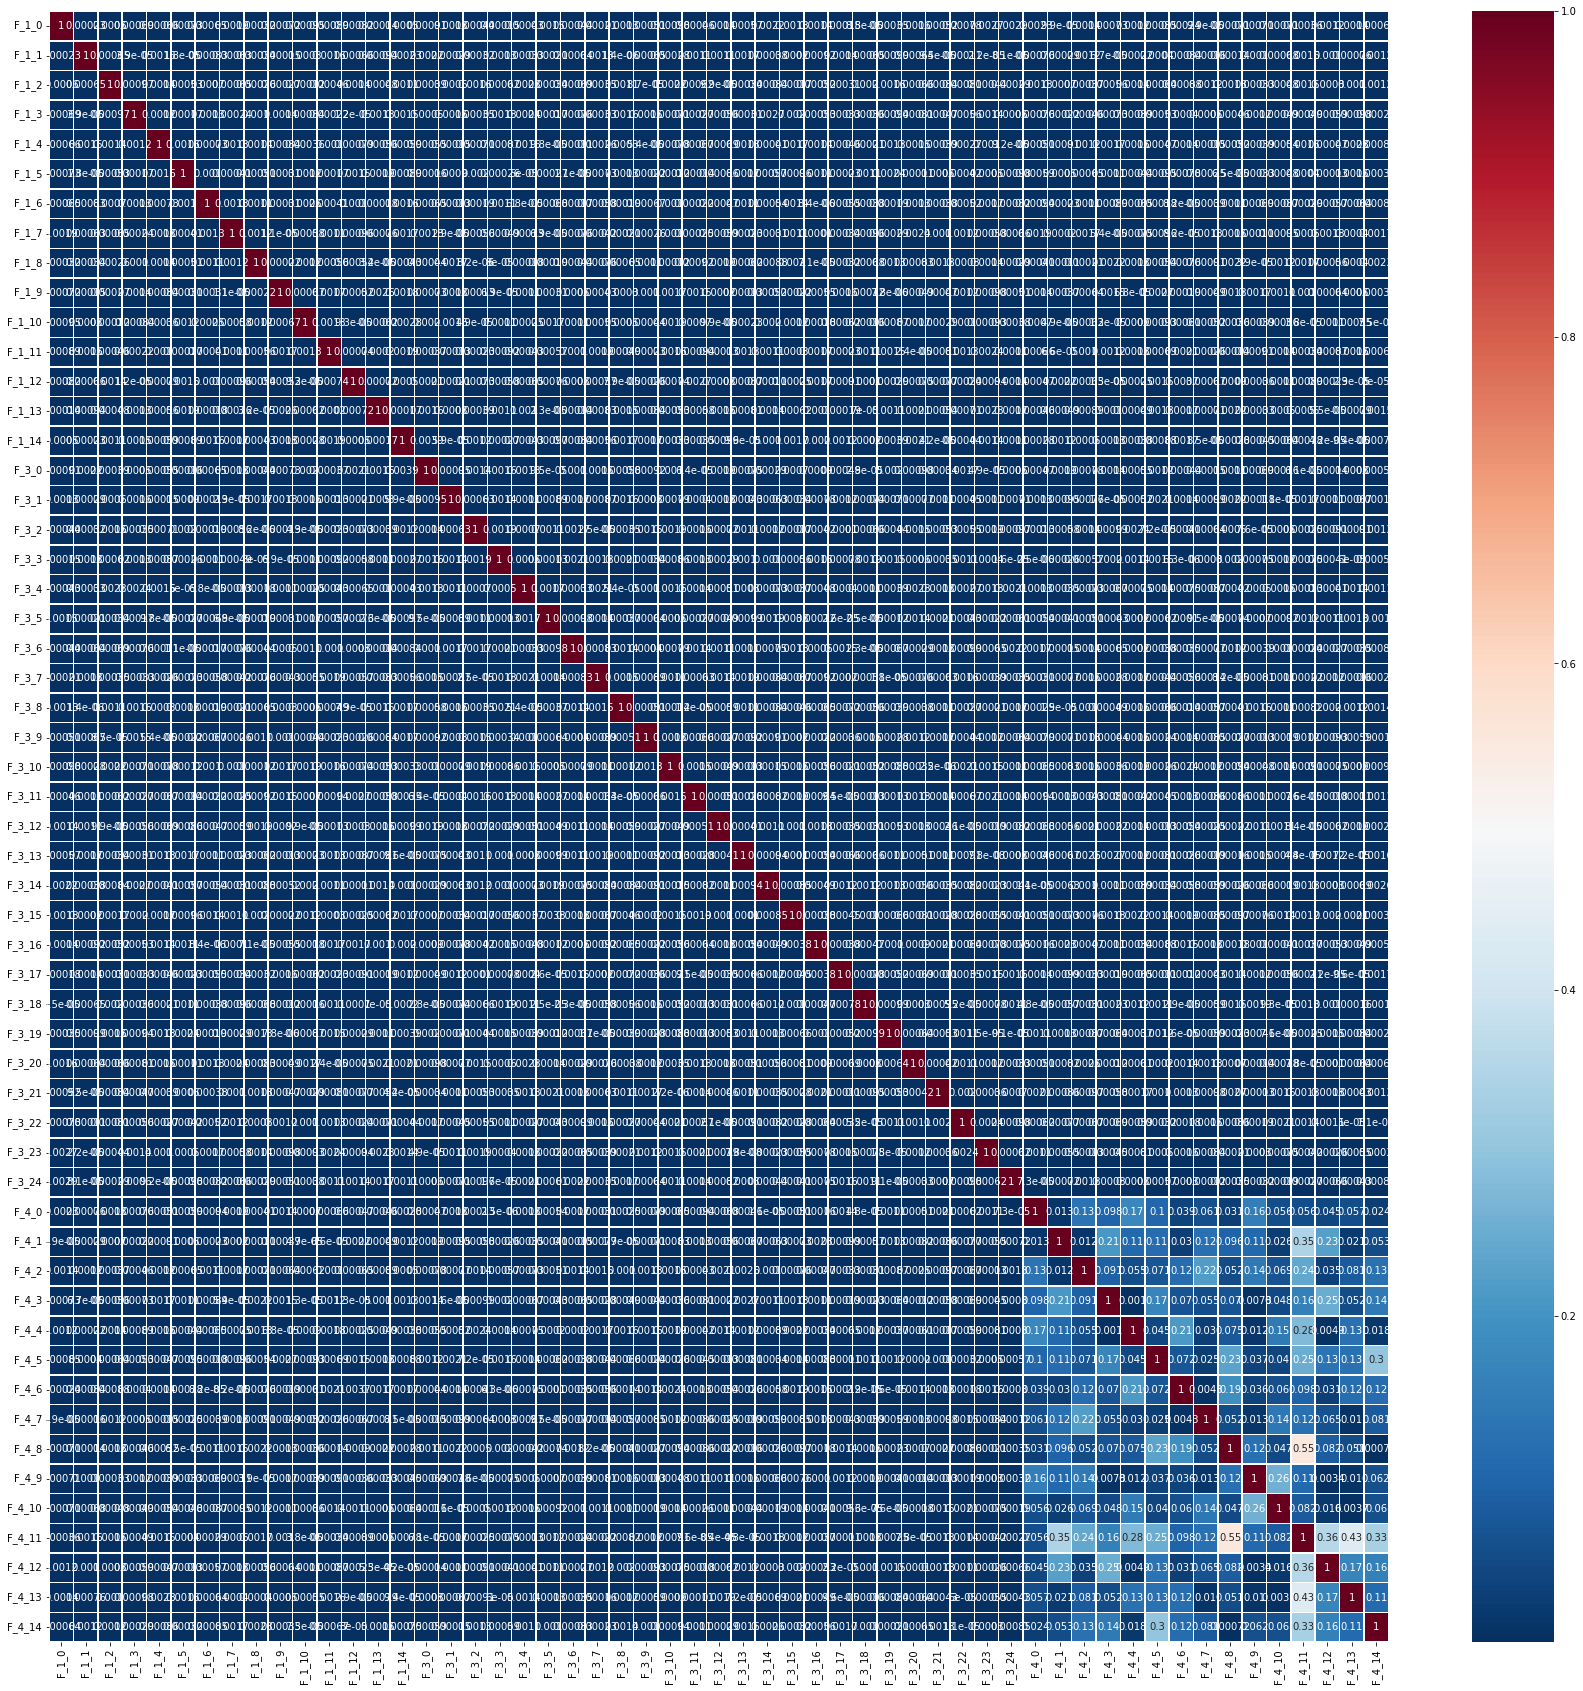

In [12]:
# correlation of all columns containing nans

pearsoncorr = data.loc[:, data.columns[~mask_int64]].corr()

plt.figure(figsize=(30, 30))
sns.heatmap(np.abs(pearsoncorr), 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

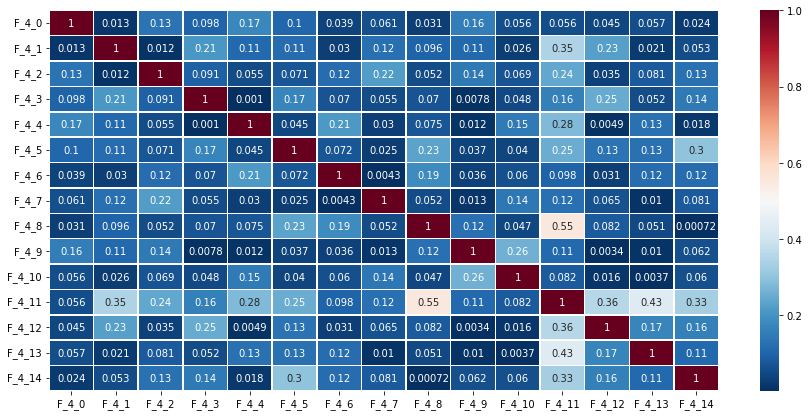

In [13]:
# shows correlations of columns starting with F_4 only

pearsoncorr_4 = pearsoncorr.loc[[row for row in pearsoncorr.index if row.split('_')[1] == '4'],
                                [col for col in pearsoncorr.columns if (col.split('_')[1] == '4')]]

plt.figure(figsize=(15, 7))
sns.heatmap(np.abs(pearsoncorr_4), 
            xticklabels=pearsoncorr_4.columns,
            yticklabels=pearsoncorr_4.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [14]:
print(f"""Columns with nans have an average of {round(data.loc[:, data.columns[~mask_int64]].isna().mean().mean()*100, 2)} % nans
with a mininum of {round(data.loc[:, data.columns[~mask_int64]].isna().mean().min()*100,2)} % of nans
and a maximum of {round(data.loc[:, data.columns[~mask_int64]].isna().mean().max()*100, 2)} % of nans""")

Columns with nans have an average of 1.82 % nans
with a mininum of 1.8 % of nans
and a maximum of 1.85 % of nans


In [ ]:
list_F_4 = [col for col in pearsoncorr.columns if (col.split('_')[1] == '4')]
data_F_4 = data.loc[:, list_F_4]

d = {}

train_percentage = .1

for col_4 in list_F_4:
    clf = LGBMRegressor(n_estimators=20000,metric='rmse')
    X, y = data_F_4[set(list_F_4).difference({col_4})], data_F_4[[col_4]]

    idx_train = list(y[~y[col_4].isna()].index)
    train_size = round(len(idx_train)*train_percentage)
    idx_train = random.sample(idx_train, train_size)
    idx_test = list(y[y[col_4].isna()].index)

    X_train , y_train, X_test, y_test = X.loc[idx_train], y.loc[idx_train], X.loc[idx_test], y.loc[idx_test]
    print("\nBeginning ", col_4, "training with training size: ", X_train.shape[0], "& test size: ", X_test.shape[0])
    clf.fit(X_train, y_train)
    d[col_4] = clf.predict(X_test)
    print(col_4 + " processed")
    score = mean_squared_error(y_train, clf.predict(X_train), squared=False)
    print('RMSE of this column : ', score)


Beginning  F_4_0 training with training size:  98187 & test size:  18128
F_4_0 processed
RMSE of this column :  0.03657175049713646

Beginning  F_4_1 training with training size:  98184 & test size:  18164
F_4_1 processed
RMSE of this column :  0.026427406093609357

Beginning  F_4_2 training with training size:  98150 & test size:  18495
F_4_2 processed
RMSE of this column :  0.008712112837447133

Beginning  F_4_3 training with training size:  98197 & test size:  18029
F_4_3 processed
RMSE of this column :  0.01586461674038452

Beginning  F_4_4 training with training size:  98204 & test size:  17957
F_4_4 processed
RMSE of this column :  0.019769231889435055

Beginning  F_4_5 training with training size:  98194 & test size:  18063
F_4_5 processed
RMSE of this column :  0.021671744352169592

Beginning  F_4_6 training with training size:  98168 & test size:  18325
F_4_6 processed
RMSE of this column :  0.04667707112116353

Beginning  F_4_7 training with training size:  98199 & test size

In [ ]:
for col in list(d.keys()):
    data[col][data[col].isna()] = d[col]

In [ ]:
print(f"Columns starting with F_4 now have {data[list_F_4].isna().sum().sum()} nans left")

In [ ]:
imp = SimpleImputer(
         missing_values=np.nan,
         strategy='mean') 
data[:] = imp.fit_transform(data)

In [ ]:
print(f"The whole dataset now has {data.isna().sum().sum()} nans left")

In [ ]:
def automated_sub_func_melt(data, sub):

    melt_data = pd.melt(data.reset_index(), id_vars='row_id', value_vars=data.columns, var_name='Column', value_name='Value')
    melt_data['row_id'] = melt_data['row_id'].astype(np.int32)
    melt_data['row-col'] = melt_data['row_id'].astype(str) + '-' + melt_data['Column']
    melt_data = melt_data.loc[melt_data['row-col'].isin(sub['row-col']), :]
    melt_data['sort1'] = melt_data['Column'].str.split('_', expand=True)[1]
    melt_data['sort1'] = melt_data['sort1'].astype(np.int8)
    melt_data['sort2'] = melt_data['Column'].str.split('_', expand=True)[2]
    melt_data['sort2'] = melt_data['sort2'].astype(np.int8)
    melt_data.sort_values(['row_id', 'sort1', 'sort2'], ascending=True, inplace=True)
    sub['value'] = melt_data['Value'].values
    return sub

In [ ]:
start_time = time.time()
new_sub = automated_sub_func_melt(data, sub.copy())
print(time.time() - start_time, "seconds")
new_sub.head()

In [ ]:
path_save = '/content/drive/MyDrive/OpenClassRooms/Projet 8/predictions.csv'
new_sub.to_csv(path_save, index = False)